In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1 import make_axes_locatable

%run ../global_variables.py ./
%run ../global_functions.py ./

In [2]:
%matplotlib notebook

basins=load_basins_data(approximate=False)

In [3]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.drop([159,22,23],inplace=True) # Antarctica, Greenland,Seven seas (tiny islands Indian ocean)

In [4]:
Nbasins=basins.shape[0]
Ndatasets=1694
data_TWS='GRACE_JPL_mascons'
min_year=2003
max_year=2014

NSEc_tab=pd.read_csv("../results/water_budget/NSE_cyclic_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])
NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])
perc_tab=pd.read_csv("../results/water_budget/GRACE_uncertainty_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])

basins_gamma=pd.read_csv('../results/basins_gamma.csv',index_col=[0])

In [5]:
annual_P=pd.read_csv('../results/annual_comp/P.csv',index_col=[0])
annual_ET=pd.read_csv('../results/annual_comp/ET.csv',index_col=[0])
annual_R=pd.read_csv('../results/annual_comp/R.csv',index_col=[0])

In [6]:
basins['max NSE']=pd.Series(np.nanmax(NSE_tab,axis=1),index=NSE_tab.index,name='max NSE')
basins['max NSEc']=pd.Series(np.nanmax(NSEc_tab,axis=1),index=NSEc_tab.index,name='max NSEc')

In [7]:
short_list_data_P=['ERA5 Land','MERRA2','JRA55',
             'CPC','CRU','GPCC',
             'GPCP','GPM','TRMM','MSWEP','Princeton']
short_list_data_ET=['ERA5 Land','MERRA2','JRA55',
              'CLSM2.0','CLSM2.1','CLSM2.2','NOAH2.0','NOAH2.1',
              'VIC2.0','VIC2.1',
              'GLEAM','MOD16','SSEBop','FLUXCOM']
short_list_data_R=['ERA5 Land','MERRA2','JRA55',
              'CLSM2.0','CLSM2.1','CLSM2.2','NOAH2.0','NOAH2.1',
              'VIC2.0','VIC2.1',
              'GRUN']

list_data_P=['ERA5_Land','MERRA2','JRA55',
             'CPC','CRU','GPCC',
             'GPCP','GPM','TRMM','MSWEP','GLDAS20']
list_data_ET=['ERA5_Land','MERRA2','JRA55',
              'GLDAS20_CLSM25','GLDAS21_CLSM25','GLDAS22_CLSM25','GLDAS20_NOAH36','GLDAS21_NOAH36',
              'GLDAS20_VIC412','GLDAS21_VIC412',
              'GLEAM','MOD16','SSEBop','FLUXCOM']
list_data_R=['ERA5_Land','MERRA2','JRA55',
              'GLDAS20_CLSM25','GLDAS21_CLSM25','GLDAS22_CLSM25','GLDAS20_NOAH36','GLDAS21_NOAH36',
              'GLDAS20_VIC412','GLDAS21_VIC412',
              'GRUN']

<IPython.core.display.Javascript object>


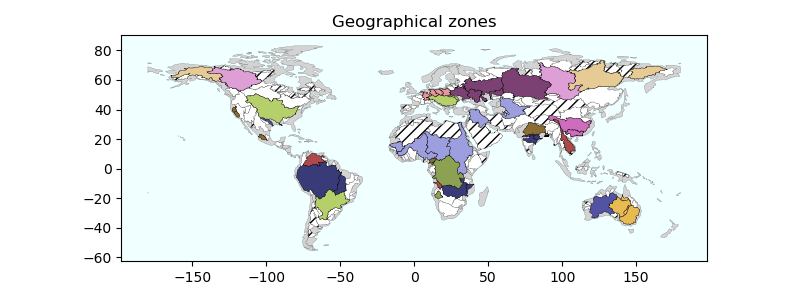

In [8]:
fig, ax = plt.subplots(figsize=(8,3))
ax.set_aspect('equal')
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
basins.plot(ax=ax,facecolor='white',edgecolor='black',linewidth=0.1)
basins.loc[(basins['max NSEc']<0)&(basins['max NSE']<0.8)].plot(ax=ax,facecolor='white',hatch='///',
                                      edgecolor='black',linewidth=0.1)
basins.loc[basins['zone']!='other'].plot(ax=ax,column='zone',categorical=True,
                                         cmap='tab20b',
                                         edgecolor='black',linewidth=0.2)

ax.set_facecolor("azure")
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_xlim([-170,180])
#ax.set_ylim([-60,85])
ax.set_title('Geographical zones')
plt.tight_layout()
plt.show()

Define the cost matrix for all basins

In [9]:
Sdiff=basins['max NSE'].values.reshape(basins.shape[0],1)-NSE_tab

# replace nans by 100, otherwise nans are summed as zeros
Sdiff=pd.DataFrame(np.where(np.isnan(Sdiff),100,Sdiff),Sdiff.index,Sdiff.columns)

# 1. Select combinations that satisfy all basins in a given zone.

In [10]:
selected_basins=basins.loc[(basins['max NSEc']>0.1)|(basins['max NSE']>0.8)]

In [11]:
np.unique(selected_basins['zone'])

array(['Amazon', 'Brazos', 'Chad', 'Congo', 'Danube', 'Ganges',
       'Lake Eyre', 'Lena', 'Orinoco', 'Rhine', 'Volga', 'Yangtze',
       'Yenisey', 'other'], dtype=object)

In [22]:
max_cost=0.1

list_zones=list(np.unique(selected_basins['zone']))
list_zones.remove('other')

combination_zone=pd.DataFrame(np.ones((len(list_zones),14),dtype='str'),
                              index=list_zones,columns=np.arange(14))
combination_zone.loc[list_zones]='none'

for zone in list_zones:
    index_zone=selected_basins.loc[selected_basins['zone']==zone].index
    
    # sum the costs over all basins
    sum_cost=np.sum(Sdiff.loc[index_zone],axis=0).sort_values()
    eligible_comb=sum_cost.loc[sum_cost<=2*max_cost*index_zone.shape[0]]

    if eligible_comb.shape[0]>0:
        # select combination that satisfy the maximum cost for all basins
        zone_cost=Sdiff.loc[index_zone,eligible_comb.index]
        zone_cost.loc['non satisfied basins']=np.sum(zone_cost>max_cost,axis=0)
        suitable_combs=zone_cost.loc[:,zone_cost.loc['non satisfied basins']==0].columns
        n=suitable_combs.shape[0]
        print('{}: {} basins, {} combinations'.format(zone,index_zone.shape[0],n))

    #    if n<=1:
    #        zone_cost=Sdiff.loc[index_zone,eligible_comb.index]
    #        zone_cost.loc['non satisfied basins']=np.sum(zone_cost>0.16,axis=0)
    #        suitable_combs=zone_cost.loc[:,zone_cost.loc['non satisfied basins']==0].columns
    #        n=suitable_combs.shape[0]

        # save the results
        combination_zone.loc[zone,np.arange(n)]=suitable_combs

combination_zone

Amazon: 8 basins, 9 combinations
Brazos: 2 basins, 4 combinations
Chad: 6 basins, 14 combinations
Congo: 2 basins, 11 combinations
Danube: 4 basins, 5 combinations
Ganges: 5 basins, 8 combinations
Lake Eyre: 4 basins, 5 combinations
Lena: 3 basins, 7 combinations
Orinoco: 3 basins, 9 combinations
Rhine: 4 basins, 11 combinations
Volga: 5 basins, 10 combinations
Yangtze: 2 basins, 5 combinations
Yenisey: 2 basins, 8 combinations


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Amazon,P_GPCP_ET_GLDAS22_CLSM25_R_GRUN_TWS_GRACE_JPL_...,P_MSWEP_ET_GLDAS22_CLSM25_R_GLDAS22_CLSM25_TWS...,P_GPCP_ET_SSEBop_R_GRUN_TWS_GRACE_JPL_mascons,P_GPCP_ET_GLDAS22_CLSM25_R_GLDAS22_CLSM25_TWS_...,P_GPCC_ET_GLDAS22_CLSM25_R_GRUN_TWS_GRACE_JPL_...,P_ERA5_Land_ET_GLDAS21_CLSM25_R_GLDAS20_CLSM25...,P_TRMM_ET_GLDAS21_CLSM25_R_GLDAS21_CLSM25_TWS_...,P_GPCP_ET_GLDAS20_CLSM25_R_GLDAS20_CLSM25_TWS_...,P_TRMM_ET_GLDAS22_CLSM25_R_GLDAS22_CLSM25_TWS_...,none,none,none,none,none
Brazos,P_ERA5_Land_ET_GLDAS20_NOAH36_R_MERRA2_TWS_GRA...,P_ERA5_Land_ET_GLDAS20_NOAH36_R_GLDAS22_CLSM25...,P_ERA5_Land_ET_GLDAS20_NOAH36_R_GLDAS20_CLSM25...,P_ERA5_Land_ET_GLDAS22_CLSM25_R_GLDAS20_CLSM25...,none,none,none,none,none,none,none,none,none,none
Chad,P_GLDAS20_ET_GLDAS20_CLSM25_R_GLDAS20_CLSM25_T...,P_GPCP_ET_GLDAS21_CLSM25_R_GLDAS21_CLSM25_TWS_...,P_GPCC_ET_GLDAS20_CLSM25_R_GLDAS21_CLSM25_TWS_...,P_GPCC_ET_GLDAS20_CLSM25_R_GLDAS20_CLSM25_TWS_...,P_GLDAS20_ET_GLDAS20_CLSM25_R_GLDAS22_CLSM25_T...,P_GPM_ET_GLDAS21_CLSM25_R_GLDAS21_CLSM25_TWS_G...,P_GLDAS20_ET_GLDAS20_CLSM25_R_MERRA2_TWS_GRACE...,P_GPCC_ET_GLDAS20_CLSM25_R_MERRA2_TWS_GRACE_JP...,P_GPM_ET_GLDAS21_CLSM25_R_GLDAS20_CLSM25_TWS_G...,P_GPCP_ET_GLDAS21_CLSM25_R_GLDAS20_CLSM25_TWS_...,P_TRMM_ET_GLDAS20_CLSM25_R_GRUN_TWS_GRACE_JPL_...,P_GPCP_ET_GLDAS21_CLSM25_R_MERRA2_TWS_GRACE_JP...,P_GPM_ET_GLDAS20_CLSM25_R_GRUN_TWS_GRACE_JPL_m...,P_TRMM_ET_GLDAS20_CLSM25_R_GLDAS22_CLSM25_TWS_...
Congo,P_ERA5_Land_ET_ERA5_Land_R_ERA5_Land_TWS_GRACE...,P_MSWEP_ET_GLEAM_R_GLDAS20_CLSM25_TWS_GRACE_JP...,P_ERA5_Land_ET_GLEAM_R_GLDAS20_CLSM25_TWS_GRAC...,P_ERA5_Land_ET_ERA5_Land_R_GLDAS20_CLSM25_TWS_...,P_MSWEP_ET_GLEAM_R_GLDAS21_CLSM25_TWS_GRACE_JP...,P_ERA5_Land_ET_JRA55_R_ERA5_Land_TWS_GRACE_JPL...,P_ERA5_Land_ET_GLEAM_R_GLDAS21_CLSM25_TWS_GRAC...,P_ERA5_Land_ET_SSEBop_R_GLDAS20_CLSM25_TWS_GRA...,P_ERA5_Land_ET_ERA5_Land_R_GLDAS21_CLSM25_TWS_...,P_ERA5_Land_ET_ERA5_Land_R_JRA55_TWS_GRACE_JPL...,P_GPCC_ET_GLDAS20_CLSM25_R_GLDAS20_CLSM25_TWS_...,none,none,none
Danube,P_GLDAS20_ET_GLDAS20_CLSM25_R_GLDAS20_CLSM25_T...,P_GLDAS20_ET_GLDAS22_CLSM25_R_GLDAS20_CLSM25_T...,P_GPCC_ET_GLDAS20_CLSM25_R_GLDAS21_CLSM25_TWS_...,P_MERRA2_ET_GLDAS20_CLSM25_R_GLDAS20_CLSM25_TW...,P_CPC_ET_GLDAS20_CLSM25_R_GLDAS20_CLSM25_TWS_G...,none,none,none,none,none,none,none,none,none
Ganges,P_GLDAS20_ET_GLDAS20_CLSM25_R_GLDAS20_CLSM25_T...,P_GPCP_ET_GLDAS21_CLSM25_R_GLDAS20_CLSM25_TWS_...,P_GPCP_ET_GLDAS21_CLSM25_R_GLDAS21_CLSM25_TWS_...,P_MERRA2_ET_GLDAS20_CLSM25_R_MERRA2_TWS_GRACE_...,P_GPCC_ET_GLDAS21_CLSM25_R_GLDAS20_CLSM25_TWS_...,P_GPCC_ET_GLDAS20_CLSM25_R_GLDAS20_CLSM25_TWS_...,P_GPCC_ET_GLDAS21_CLSM25_R_GLDAS21_CLSM25_TWS_...,P_GPM_ET_GLDAS21_CLSM25_R_GLDAS21_CLSM25_TWS_G...,none,none,none,none,none,none
Lake Eyre,P_GPCP_ET_GLDAS21_CLSM25_R_GLDAS20_CLSM25_TWS_...,P_GPCP_ET_GLDAS21_CLSM25_R_GLDAS21_CLSM25_TWS_...,P_GLDAS20_ET_GLDAS20_CLSM25_R_GLDAS20_CLSM25_T...,P_GPCP_ET_GLDAS21_CLSM25_R_MERRA2_TWS_GRACE_JP...,P_GPCP_ET_GLDAS21_CLSM25_R_GLDAS22_CLSM25_TWS_...,none,none,none,none,none,none,none,none,none
Lena,P_GPCP_ET_GLDAS21_VIC412_R_ERA5_Land_TWS_GRACE...,P_GPCC_ET_GLDAS21_VIC412_R_GRUN_TWS_GRACE_JPL_...,P_GPM_ET_GLDAS21_VIC412_R_ERA5_Land_TWS_GRACE_...,P_GPCP_ET_ERA5_Land_R_GRUN_TWS_GRACE_JPL_mascons,P_GPM_ET_ERA5_Land_R_GRUN_TWS_GRACE_JPL_mascons,P_GPCC_ET_GLDAS21_VIC412_R_JRA55_TWS_GRACE_JPL...,P_GPCC_ET_GLDAS21_VIC412_R_ERA5_Land_TWS_GRACE...,none,none,none,none,none,none,none
Orinoco,P_ERA5_Land_ET_GLDAS21_CLSM25_R_GLDAS21_CLSM25...,P_GPCP_ET_GLDAS21_CLSM25_R_GLDAS21_CLSM25_TWS_...,P_GPCC_ET_JRA55_R_GRUN_TWS_GRACE_JPL_mascons,P_GPCC_ET_GLDAS20_NOAH36_R_GRUN_TWS_GRACE_JPL_...,P_GPCC_ET_GLDAS21_NOAH36_R_GRUN_TWS_GRACE_JPL_...,P_GPM_ET_GLDAS21_CLSM25_R_GLDAS21_CLSM25_TWS_G...,P_GPCC_ET_SSEBop_R_GRUN_TWS_GRACE_JPL_mascons,P_GPCC_ET_GLEAM_R_GRUN_TWS_GRACE_JPL_mascons,P_GLDAS20_ET_GLDAS20_CLSM25_R_GLDAS20_CLSM25_T...,none,none,none,none,none
Rhine,P_MSWEP_ET_GLDAS21_VIC412_R_GRUN_TWS_GRACE_JPL...,

For each zone, compute the number of combinations in which a given dataset appears.

In [32]:
stats_P=pd.DataFrame(np.zeros((len(list_zones),len(list_data_P))),
                     index=list_zones,
                     columns=list_data_P)
stats_ET=pd.DataFrame(np.zeros((len(list_zones),len(list_data_ET))),
                      index=list_zones,
                      columns=list_data_ET)
stats_R=pd.DataFrame(np.zeros((len(list_zones),len(list_data_R))),
                     index=list_zones,
                     columns=list_data_R)

for zone in list_zones:
    # select all combinations lower than the maximal cost    
    comb_ok=combination_zone.loc[zone,combination_zone.loc[zone]!='none'].values
    
    # extract the datasets from those combinations
    temp=np.array(list(map(decompose_dataset,comb_ok)))
    data_P=temp[:,0]
    data_ET=temp[:,1]
    data_R=temp[:,2]
    
    # count the number of occurences of each dataset
    unique_P,counts_P=np.unique(data_P,return_counts=True)
    stats_P.loc[zone,unique_P]=counts_P
    
    unique_ET,counts_ET=np.unique(data_ET,return_counts=True)
    stats_ET.loc[zone,unique_ET]=counts_ET
    
    unique_R,counts_R=np.unique(data_R,return_counts=True)
    stats_R.loc[zone,unique_R]=counts_R
    
percentage=True
if percentage:      
    stats_P=100*stats_P/stats_P.sum(axis=1).to_frame().values
    stats_ET=100*stats_ET/stats_ET.sum(axis=1).to_frame().values
    stats_R=100*stats_R/stats_R.sum(axis=1).to_frame().values

Mean annual P, ET, and R to normalize

In [33]:
P_mean=pd.Series(np.zeros(stats_P.shape[0]),index=stats_P.index)
ET_mean=pd.Series(np.zeros(stats_ET.shape[0]),index=stats_ET.index)
R_mean=pd.Series(np.zeros(stats_R.shape[0]),index=stats_R.index)
for zone in stats_P.index:
    ok_data_P=stats_P.columns[np.where(stats_P.loc[zone]>0)[0]]
    ok_data_ET=stats_ET.columns[np.where(stats_ET.loc[zone]>0)[0]]
    ok_data_R=stats_R.columns[np.where(stats_R.loc[zone]>0)[0]]
    
    basins_in_zone=selected_basins.loc[selected_basins['zone']==zone].index
    
    P_mean.loc[zone]=annual_P.loc[basins_in_zone,ok_data_P].mean().mean()
    ET_mean.loc[zone]=annual_ET.loc[basins_in_zone,ok_data_ET].mean().mean()
    R_mean.loc[zone]=annual_R.loc[basins_in_zone,ok_data_R].mean().mean()

In [34]:
def plot_bars(x,y,zone_name,ax,height=5,length_norm=0.3):
    # P
    left=x
    for data in list_data_P:
        length=length_norm*stats_P.loc[zone_name,data]
        ax.barh(y+2*height,length,left=left,
                 label=dict_dataset_name[data],color=colors_dataset[data],height=height)
        left+=length
    
    # ET
    left=x
    for data in list_data_ET:
        length=length_norm*(ET_mean.loc[zone_name]/P_mean.loc[zone_name])*stats_ET.loc[zone_name,data]
        ax.barh(y+0.6*height,length,left=left,
                 label=dict_dataset_name[data],color=colors_dataset[data],height=height)
        left+=length
    
    plt.plot([left,left],[y+0.1*height,y+1.1*height],'k',linewidth=2)
    for data in list_data_R:
        length=length_norm*(R_mean.loc[zone_name]/P_mean.loc[zone_name])*stats_R.loc[zone_name,data]
        ax.barh(y+0.6*height,length,left=left,
                 label=dict_dataset_name[data],color=colors_dataset[data],height=height)
        left+=length

In [35]:
draw_zone=pd.DataFrame(np.zeros((len(list_zones),2)),index=list_zones,columns=['x','y'])
draw_zone.loc['Amazon']=[-104,-14]
draw_zone.loc['Brazos']=[90,-34]
draw_zone.loc['Chad']=[19,9]
draw_zone.loc['Congo']=[-20,-16]
draw_zone.loc['Danube']=[5,26]
draw_zone.loc['Ganges']=[75,-2]
draw_zone.loc['Lake Eyre']=[130,-55]
draw_zone.loc['Lena']=[130,68]
#draw_zone.loc['Orange']=[0,-47]
draw_zone.loc['Orinoco']=[-73,12]
draw_zone.loc['Rhine']=[-5,60]
draw_zone.loc['Volga']=[43,68]
draw_zone.loc['Yangtze']=[125,22]
draw_zone.loc['Yenisey']=[-105,67]

<IPython.core.display.Javascript object>


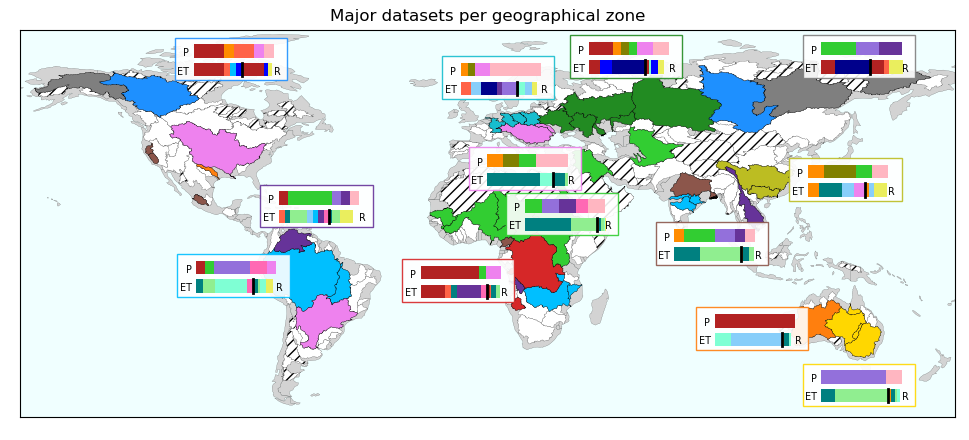

In [36]:
fig, ax = plt.subplots(figsize=(9.7,4.4))
ax.set_aspect('equal')
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
basins.plot(ax=ax,facecolor='white',edgecolor='black',linewidth=0.1)
basins.loc[(basins['max NSEc']<0)&(basins['max NSE']<0.8)].plot(ax=ax,facecolor='white',hatch='///',
                                      edgecolor='black',linewidth=0.1)

for zone in list_zones:
    selected_basins.loc[selected_basins['zone']==zone].plot(ax=ax,color=dict_color_zone[zone],
                                                           edgecolor='black',linewidth=0.2)
    ax.fill([draw_zone.loc[zone,'x']-7,draw_zone.loc[zone,'x']+35,draw_zone.loc[zone,'x']+35,draw_zone.loc[zone,'x']-7],
           [draw_zone.loc[zone,'y']-1,draw_zone.loc[zone,'y']-1,draw_zone.loc[zone,'y']+15,draw_zone.loc[zone,'y']+15],
           facecolor='white',alpha=0.9,edgecolor=dict_color_zone[zone])
    plot_bars(draw_zone.loc[zone,'x'],draw_zone.loc[zone,'y'],zone,ax)
    plt.text(draw_zone.loc[zone,'x']-4,draw_zone.loc[zone,'y']+8,'P',fontsize='x-small')
    plt.text(draw_zone.loc[zone,'x']-6,draw_zone.loc[zone,'y']+1.2,'ET',fontsize='x-small')
    plt.text(draw_zone.loc[zone,'x']+30,draw_zone.loc[zone,'y']+1.2,'R',fontsize='x-small')
    
ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('Major datasets per geographical zone')
plt.tight_layout()
plt.show()

# 2. Select all datasets below a given cost (for each basin individually)

In [10]:
max_cost=0.05
Sdiff_bool=pd.DataFrame(np.where(Sdiff<=max_cost,Sdiff,'none'),index=Sdiff.index,columns=Sdiff.columns)

my_index=basins.loc[(basins['max NSEc']>=0.1)|(basins['max NSE']>0.8)].index
nb_comb_ok=np.sum(Sdiff_bool!='none',axis=1)
np.percentile(nb_comb_ok,50)

16.0

<IPython.core.display.Javascript object>


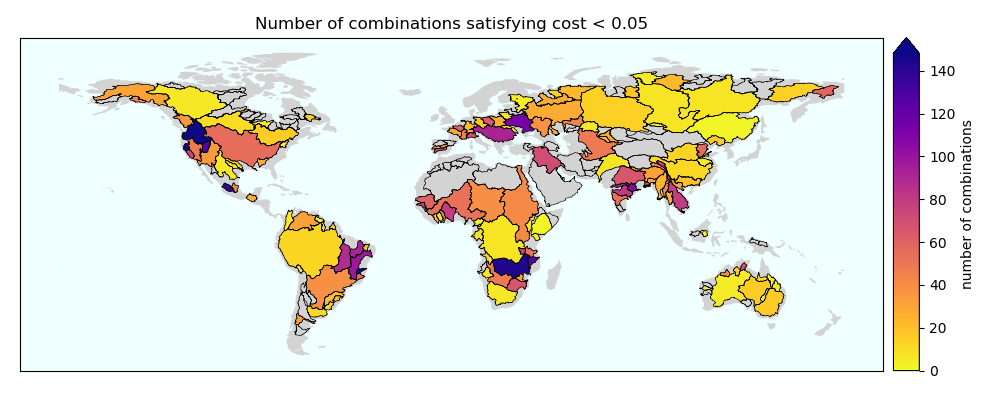

In [11]:
basins_plot=basins.loc[my_index].copy()
basins_plot['nb comb ok']=nb_comb_ok

fig, ax = plt.subplots(figsize=(9.9,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.01)
basins.boundary.plot(ax=ax,color='black',linewidth=0.4)
#basins.plot(ax=ax,color='grey',edgecolor='black',linewidth=0.5)
basins_plot.plot(ax=ax,column='nb comb ok',edgecolor='grey',linewidth=0.1,
                 cmap=plt.cm.get_cmap('plasma_r'),
                 vmin=0,
                 vmax=np.percentile(nb_comb_ok.values,98),
                 legend=True,cax=cax,
                legend_kwds={'label': "number of combinations",
                             'extend':'max'
                          },)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('azure')
ax.set_title('Number of combinations satisfying cost < {}'.format(max_cost))
plt.tight_layout()
plt.show()

Plot the legend for datasets

<IPython.core.display.Javascript object>


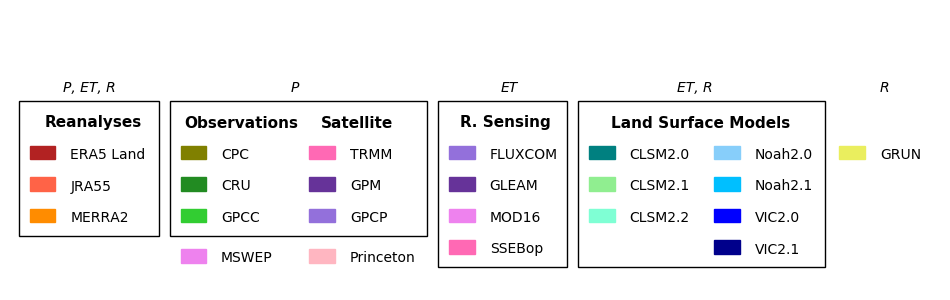

In [13]:
box_height=0.3
box_width=0.7

plt.figure(figsize=(9.5,3))
plt.axis('off')
x=0.4
plt.fill([x-0.3,3.9,3.9,x-0.3],[1.1,1.1,4.1,4.1],edgecolor='black',facecolor='white')
plt.text(x+0.4,3.5,'Reanalyses',fontsize=11,fontweight='bold')
y=2.8
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['ERA5_Land'])
plt.text(x+1.1,y,'ERA5 Land')
y=2.1
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['JRA55'])
plt.text(x+1.1,y,'JRA55')
y=1.4
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['MERRA2'])
plt.text(x+1.1,y,'MERRA2')

x=4.5
plt.fill([x-0.3,11.2,11.2,x-0.3],[1.1,1.1,4.1,4.1],edgecolor='black',facecolor='white')
plt.text(x+0.1,3.5,'Observations',fontsize=11,fontweight='bold')
y=2.8
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['CPC'])
plt.text(x+1.1,y,'CPC')
y=2.1
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['CRU'])
plt.text(x+1.1,y,'CRU')
y=1.4
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['GPCC'])
plt.text(x+1.1,y,'GPCC')
y=0.5
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['MSWEP'])
plt.text(x+1.1,y,'MSWEP')

x=8
plt.text(x+0.3,3.5,'Satellite',fontsize=11,fontweight='bold')
y=2.8
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['TRMM'])
plt.text(x+1.1,y,'TRMM')
y=2.1
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['GPM'])
plt.text(x+1.1,y,'GPM')
y=1.4
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['GPCP'])
plt.text(x+1.1,y,'GPCP')
y=0.5
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['GLDAS20'])
plt.text(x+1.1,y,'Princeton')

x=11.8
plt.fill([x-0.3,15,15,x-0.3],[0.4,0.4,4.1,4.1],edgecolor='black',facecolor='white')
plt.text(x+0.3,3.5,'R. Sensing',fontsize=11,fontweight='bold')
y=2.8
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['FLUXCOM'])
plt.text(x+1.1,y,'FLUXCOM')
y=2.1
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['GLEAM'])
plt.text(x+1.1,y,'GLEAM')
y=1.4
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['MOD16'])
plt.text(x+1.1,y,'MOD16')
y=0.7
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['SSEBop'])
plt.text(x+1.1,y,'SSEBop')

x=15.6
plt.fill([x-0.3,22,22,x-0.3],[0.4,0.4,4.1,4.1],edgecolor='black',facecolor='white')
plt.text(x+0.6,3.5,'Land Surface Models',fontsize=11,fontweight='bold')
y=2.8
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['CLSM2.0'])
plt.text(x+1.1,y,'CLSM2.0')
y=2.1
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['CLSM2.1'])
plt.text(x+1.1,y,'CLSM2.1')
y=1.4
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['CLSM2.2'])
plt.text(x+1.1,y,'CLSM2.2')

x=19
y=2.8
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['NOAH2.0'])
plt.text(x+1.1,y,'Noah2.0')
y=2.1
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['NOAH2.1'])
plt.text(x+1.1,y,'Noah2.1')
y=1.4
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['VIC2.0'])
plt.text(x+1.1,y,'VIC2.0')
y=0.7
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['VIC2.1'])
plt.text(x+1.1,y,'VIC2.1')

x=22.4
y=2.8
plt.fill([x,x+box_width,x+box_width,x],[y,y,y+box_height,y+box_height],color=colors_dataset['GRUN'])
plt.text(x+1.1,y,'GRUN')


plt.text(1.3,4.3,'P, ET, R',fontstyle='italic')
plt.text(7.5,4.3,'P',fontstyle='italic')
plt.text(13.2,4.3,'ET',fontstyle='italic')
plt.text(18,4.3,'ET, R',fontstyle='italic')
plt.text(23.5,4.3,'R',fontstyle='italic')

plt.xlim([0,25])
plt.ylim([0,6])
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [12]:
def compute_discrepancy(hydro_var_name,basin_id,list_data):
    ''' We do not use the coefficient of variation because we are interested in ALL selected datasets. 
    If the selection process is correct, there should not be outliers'''
    time_idx=pd.date_range(date(2003,2,1),date(2014,12,1),freq='SM')[::2]

    df=pd.DataFrame(np.nan*np.ones((len(list_data),time_idx.shape[0])),
               index=list_data,
               columns=time_idx)

    len_data=len(list_data)
    for data in list_data:
        hydro_month=pd.read_csv('../results/hydrology/{}_{}_monthly.csv'.format(hydro_var_name,data),index_col=[0])
        hydro_selec=hydro_month.loc[basin_id,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_idx]]
        if np.sum(np.isnan(hydro_selec.values))==0:    
            df.loc[data]=hydro_selec.values
        else:
            len_data-=1      
            
    hydro_mean=df.mean(axis=0)
    discr=0.5*np.mean((np.nanmax(df,axis=0)-np.nanmin(df,axis=0))/hydro_mean)
    return discr

In [13]:
basins=load_basins_data(approximate=False)
basins['max NSE']=pd.Series(np.nanmax(NSE_tab,axis=1),index=NSE_tab.index,name='max NSE')
basins['max NSEc']=pd.Series(np.nanmax(NSEc_tab,axis=1),index=NSEc_tab.index,name='max NSEc')

In [15]:
clim='All'
my_index=basins.loc[(basins['max NSEc']>=0.1)|(basins['max NSE']>0.8)].index
#my_index=index_dendogram.copy()
if clim!='All':
    selected_index=basins.loc[my_index].loc[basins['MAIN_CLIMATE']==clim].sort_values(by=['zone']).index
else:
    selected_index=my_index

stats_P=pd.DataFrame(np.zeros((selected_index.shape[0],len(list_data_P))),
                     index=selected_index,
                     columns=list_data_P)
stats_ET=pd.DataFrame(np.zeros((selected_index.shape[0],len(list_data_ET))),
                      index=selected_index,
                      columns=list_data_ET)
stats_R=pd.DataFrame(np.zeros((selected_index.shape[0],len(list_data_R))),
                     index=selected_index,
                     columns=list_data_R)

for basin_name in selected_index:
    # select all combinations lower than the maximal cost
    #comb_ok=Sdiff.loc[basin_id,Sdiff.loc[basin_id]<=max_cost].index
    
    comb_ok=Sdiff_bool.loc[basin_name,Sdiff_bool.loc[basin_name]!='none'].index
    
    # extract the datasets from those combinations
    temp=np.array(list(map(decompose_dataset,comb_ok)))
    data_P=temp[:,0]
    data_ET=temp[:,1]
    data_R=temp[:,2]
    
    # count the number of occurences of each dataset
    unique_P,counts_P=np.unique(data_P,return_counts=True)
    stats_P.loc[basin_name,unique_P]=counts_P
    
    unique_ET,counts_ET=np.unique(data_ET,return_counts=True)
    stats_ET.loc[basin_name,unique_ET]=counts_ET
    
    unique_R,counts_R=np.unique(data_R,return_counts=True)
    stats_R.loc[basin_name,unique_R]=counts_R
    
percentage=True
remove=False
remove_threshold=5 # minimum percentage of combinations
if percentage:      
    stats_P=100*stats_P/stats_P.sum(axis=1).to_frame().values
    stats_ET=100*stats_ET/stats_ET.sum(axis=1).to_frame().values
    stats_R=100*stats_R/stats_R.sum(axis=1).to_frame().values
    if remove:
        # remove datasets present in less than 10% of the possible combinations
        stats_P=pd.DataFrame(np.where(stats_P<=remove_threshold,0,stats_P),index=stats_P.index,columns=stats_P.columns)
        stats_ET=pd.DataFrame(np.where(stats_ET<=remove_threshold,0,stats_ET),index=stats_ET.index,columns=stats_ET.columns)
        stats_R=pd.DataFrame(np.where(stats_R<=remove_threshold,0,stats_R),index=stats_R.index,columns=stats_R.columns)

Plot datasets with bar length proportional to the mean annual cycle

In [16]:
nb_comb_basin=stats_P.sum(axis=1)

P_mean=pd.Series(np.zeros(stats_P.shape[0]),index=stats_P.index)
ET_mean=pd.Series(np.zeros(stats_ET.shape[0]),index=stats_ET.index)
R_mean=pd.Series(np.zeros(stats_R.shape[0]),index=stats_R.index)
for basin_name in stats_P.index:
    ok_data_P=stats_P.columns[np.where(stats_P.loc[basin_name]>0)[0]]
    ok_data_ET=stats_ET.columns[np.where(stats_ET.loc[basin_name]>0)[0]]
    ok_data_R=stats_R.columns[np.where(stats_R.loc[basin_name]>0)[0]]
    
    P_mean.loc[basin_name]=annual_P.loc[basin_name,ok_data_P].mean()
    ET_mean.loc[basin_name]=annual_ET.loc[basin_name,ok_data_ET].mean()
    R_mean.loc[basin_name]=annual_R.loc[basin_name,ok_data_R].mean()

<IPython.core.display.Javascript object>


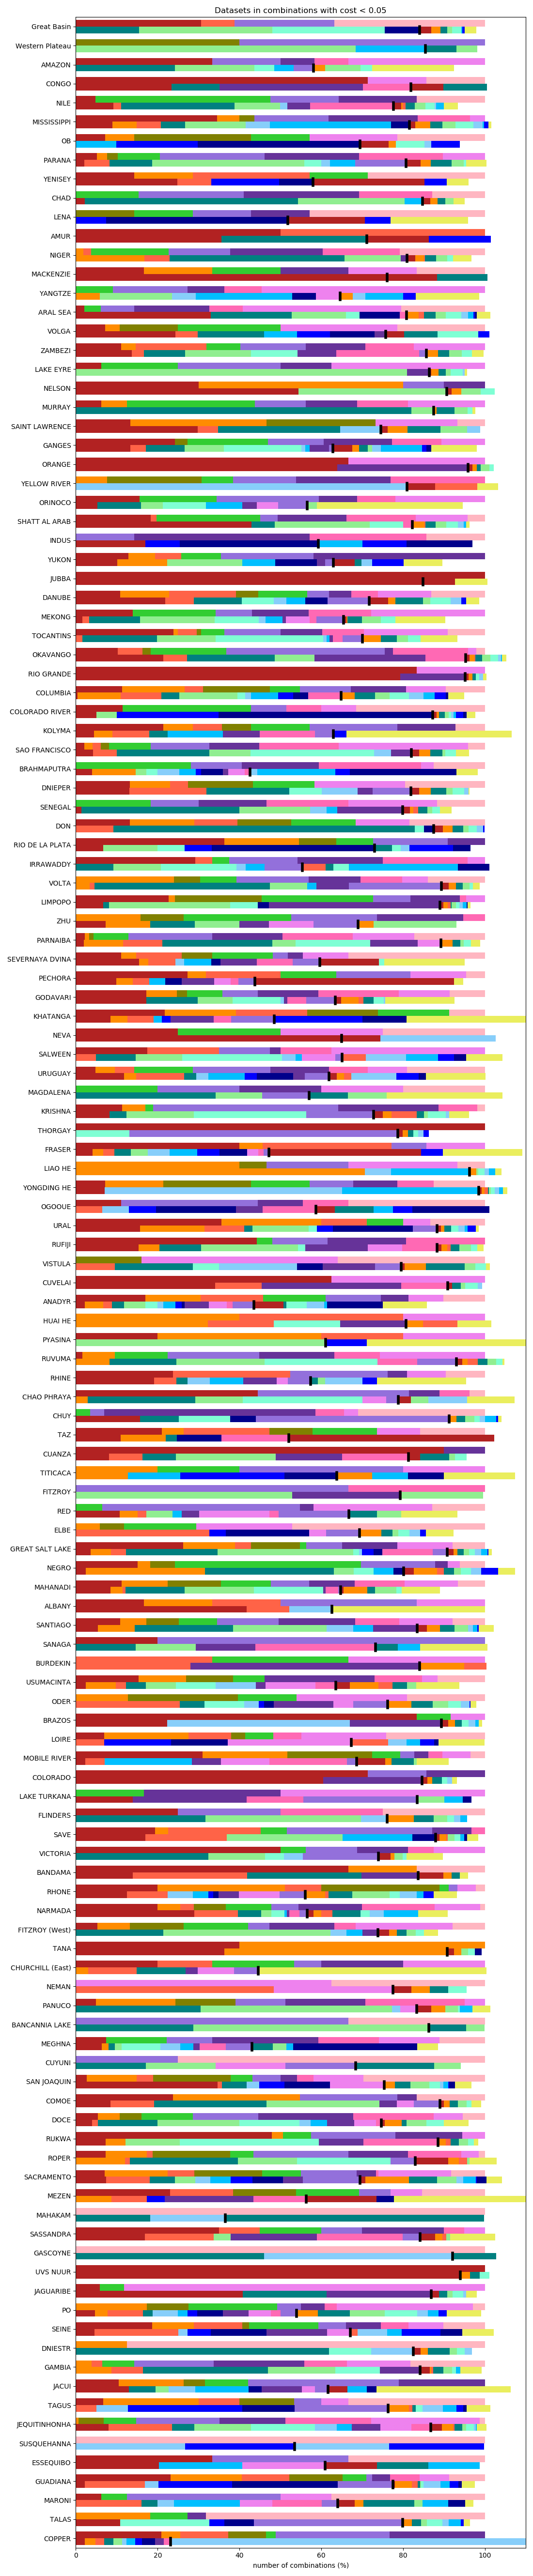

In [17]:
height=0.35
plot_P=True
plot_ET_R=True

plt.figure(figsize=(11,0.4*stats_P.shape[0]))
if plot_P:
    left=pd.Series(np.zeros(stats_P.shape[0]),index=stats_P.index)
    for data in list_data_P:
        plt.barh(np.arange(stats_P.shape[0])+height/2,stats_P[data],left=left,
                 label=dict_dataset_name[data],color=colors_dataset[data],height=height)
        left+=stats_P[data]
        
if plot_ET_R:
    left=pd.Series(np.zeros(stats_ET.shape[0]),index=stats_ET.index)
    for data in list_data_ET:
        plt.barh(np.arange(stats_P.shape[0])-height/2,(ET_mean/P_mean)*stats_ET[data],left=left,
                 label=dict_dataset_name[data],color=colors_dataset[data],height=height)
        left+=(ET_mean/P_mean)*stats_ET[data]

    #plt.legend()
    
    plt.plot([left,left],[np.arange(stats_P.shape[0])-height,np.arange(stats_P.shape[0])],'k',linewidth=4)
    for data in list_data_R:
        plt.barh(np.arange(stats_P.shape[0])-height/2,(R_mean/P_mean)*stats_R[data],left=left,
                 label=dict_dataset_name[data],color=colors_dataset[data],height=height)
        left+=(R_mean/P_mean)*stats_R[data]

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys(),loc='upper center',ncol=5,fontsize='small',bbox_to_anchor=(0.4,1.2))
        
plt.yticks(np.arange(stats_P.shape[0]),
           np.where(selected_index.astype(str)=='Great Basin except Great Salt Lake',
                    'Great Basin',selected_index.astype(str)),
          fontsize=10)
plt.xlabel('number of combinations (%)')
plt.xlim([0,110])
plt.ylim([-0.5,stats_P.shape[0]-0.5])
if clim=='All':
    plt.title('Datasets in combinations with cost < 0.05')
else:
    plt.title(climate_name_dict[clim])

plt.tight_layout()
plt.show()

## 2.2. Example in a basin

In [18]:
def compute_discrepancy_basin(hydro_var_name,basin_id,list_data,list_data_P,P_normalize=False):
    time_idx=pd.date_range(date(2003,2,1),date(2014,12,1),freq='SM')[::2]
    
    if P_normalize and hydro_var_name!='P':
        # compute P mean for the normalization
        df=pd.DataFrame(np.nan*np.ones((len(list_data_P),time_idx.shape[0])),
               index=list_data_P,
               columns=time_idx)
        for data in list_data_P:
            hydro_month=pd.read_csv('../results/hydrology/P_{}_monthly.csv'.format(data),index_col=[0])
            hydro_selec=hydro_month.loc[basin_id,['P_{} {}'.format(data,d.date()) for d in time_idx]]
            if np.sum(np.isnan(hydro_selec.values))==0:    
                df.loc[data]=hydro_selec.values
            else:
                print('warning no value for '+data)  
        hydro_mean=df.copy().mean(axis=0)
        
    df=pd.DataFrame(np.nan*np.ones((len(list_data),time_idx.shape[0])),
               index=list_data,
               columns=time_idx)
    for data in list_data:
        hydro_month=pd.read_csv('../results/hydrology/{}_{}_monthly.csv'.format(hydro_var_name,data),index_col=[0])
        hydro_selec=hydro_month.loc[basin_id,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_idx]]
        if np.sum(np.isnan(hydro_selec.values))==0:    
            df.loc[data]=hydro_selec.values
        else:
            print('warning no value for '+data)  
    
    if P_normalize==False or hydro_var_name=='P': # compute the mean from the same datasets
        hydro_mean=df.mean(axis=0)
        
    discr=0.5*np.mean((np.nanmax(df,axis=0)-np.nanmin(df,axis=0))/hydro_mean)
    return discr

<IPython.core.display.Javascript object>


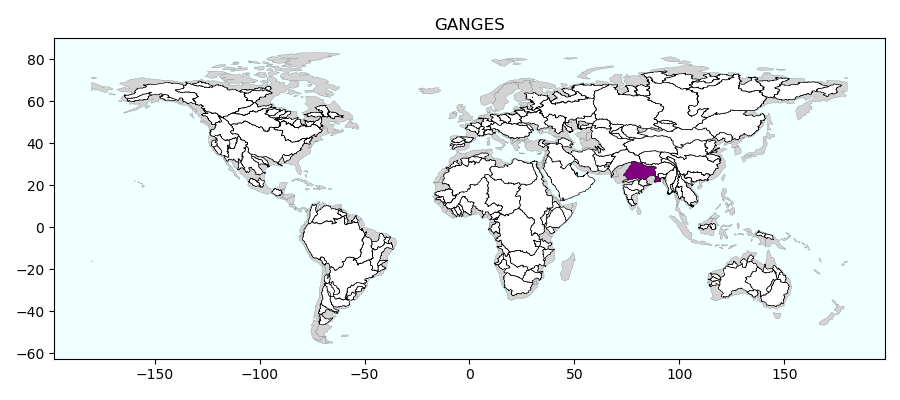

In [19]:
basin_name='GANGES'

fig, ax = plt.subplots(figsize=(9,4))
ax.set_aspect('equal')
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
basins.plot(ax=ax,color='white',edgecolor='black',linewidth=0.4)
basins.loc[[basin_name],'geometry'].plot(ax=ax, color='purple')
plt.title(basin_name)
ax.set_facecolor('azure')
plt.tight_layout()
plt.show()

Select datasets appearing in at least 5% of the combinations

In [20]:
ok_data_P=stats_P.columns[np.where(stats_P.loc[basin_name]>5)[0]]
ok_data_ET=stats_ET.columns[np.where(stats_ET.loc[basin_name]>5)[0]]
ok_data_R=stats_R.columns[np.where(stats_R.loc[basin_name]>5)[0]]

<IPython.core.display.Javascript object>


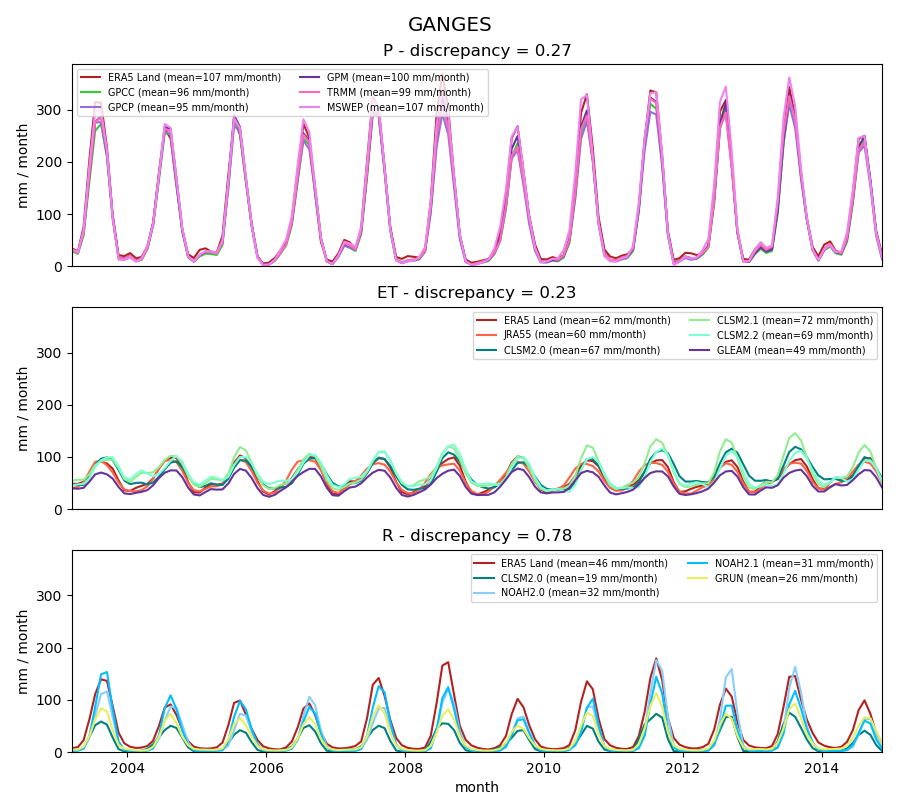

In [21]:
time_idx=pd.date_range(date(2003,3,1),date(2014,12,1),freq='SM')[::2]
vmax=0

plt.figure(figsize=(9,8))

hydro_var_name='P'
plt.subplot(3,1,1)
for data in ok_data_P:
    hydro_month=pd.read_csv('../results/hydrology/{}_{}_monthly_filtered.csv'.format(hydro_var_name,data),
                                                            index_col=[0])
    plt.plot(time_idx,hydro_month.loc[basin_name,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_idx]],
             color=colors_dataset[data],
             label='{} (mean={:.0f} mm/month)'.format(dict_dataset_name[data],
                hydro_month.loc[basin_name,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_idx]].mean()))
    vmax=max(vmax,hydro_month.loc[basin_name,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_idx]].max())
plt.legend(ncol=2,fontsize='x-small')
plt.xlim([time_idx[0],time_idx[-1]])
plt.ylim([0,1.05*vmax])
plt.title('P - discrepancy = {:.2f}'.format(compute_discrepancy_basin('P',basin_name,ok_data_P,list_data_P=ok_data_P)))
plt.xticks([2008],[''])
plt.ylabel("mm / month")

hydro_var_name='ET'
plt.subplot(3,1,2)
for data in ok_data_ET:
    hydro_month=pd.read_csv('../results/hydrology/{}_{}_monthly_filtered.csv'.format(hydro_var_name,data),
                                                       index_col=[0])
    plt.plot(time_idx,hydro_month.loc[basin_name,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_idx]],
         color=colors_dataset[data],
         label='{} (mean={:.0f} mm/month)'.format(dict_dataset_name[data],
            hydro_month.loc[basin_name,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_idx]].mean()))

plt.legend(ncol=2,fontsize='x-small')
plt.xlim([time_idx[0],time_idx[-1]])
plt.ylim([0,1.05*vmax])
plt.title('ET - discrepancy = {:.2f}'.format(compute_discrepancy_basin('ET',basin_name,ok_data_ET,list_data_P=ok_data_P)))
plt.xticks([2008],[''])
plt.ylabel("mm / month")

hydro_var_name='R'
plt.subplot(3,1,3)
for data in ok_data_R:
    hydro_month=pd.read_csv('../results/hydrology/{}_{}_monthly_filtered.csv'.format(hydro_var_name,data),
                                                        index_col=[0])
    plt.plot(time_idx,hydro_month.loc[basin_name,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_idx]],
         color=colors_dataset[data],
         label='{} (mean={:.0f} mm/month)'.format(dict_dataset_name[data],
            hydro_month.loc[basin_name,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_idx]].mean()))

plt.legend(ncol=2,fontsize='x-small')
plt.xlim([time_idx[0],time_idx[-1]])
plt.ylim([0,1.05*vmax])
plt.title('R - discrepancy = {:.2f}'.format(compute_discrepancy_basin('R',basin_name,ok_data_R,list_data_P=ok_data_P)))
plt.xlabel('month')
plt.ylabel("mm / month")

plt.suptitle("{}".format(basin_name),fontsize='x-large')

#plt.xlim([date(2002,5,1),date(2017,7,1)])
#plt.tight_layout()
plt.subplots_adjust(left=0.08,right=0.98,bottom=0.06,top=0.92)
plt.show()    

Can we mix all selected datasets?

In [22]:
datasets=[]
for d_P in ok_data_P:
    for d_ET in ok_data_ET:
        for d_R in ok_data_R:
            datasets.append('P_{}_ET_{}_R_{}_TWS_{}'.format(d_P,d_ET,d_R,data_TWS))
NSE_tab.loc[basin_name,datasets].sort_values()

P_MSWEP_ET_GLEAM_R_GLDAS20_CLSM25_TWS_GRACE_JPL_mascons        0.538214
P_ERA5_Land_ET_GLEAM_R_GLDAS20_CLSM25_TWS_GRACE_JPL_mascons    0.558967
P_GPCP_ET_GLDAS21_CLSM25_R_ERA5_Land_TWS_GRACE_JPL_mascons     0.628440
P_GPM_ET_GLEAM_R_GLDAS20_CLSM25_TWS_GRACE_JPL_mascons          0.650200
P_GPCC_ET_GLDAS21_CLSM25_R_ERA5_Land_TWS_GRACE_JPL_mascons     0.673674
                                                                 ...   
P_GPCC_ET_GLDAS20_CLSM25_R_GRUN_TWS_GRACE_JPL_mascons          0.932116
P_GPCP_ET_GLDAS22_CLSM25_R_GRUN_TWS_GRACE_JPL_mascons          0.940170
P_TRMM_ET_GLDAS22_CLSM25_R_GRUN_TWS_GRACE_JPL_mascons          0.944351
P_GPM_ET_GLDAS22_CLSM25_R_GRUN_TWS_GRACE_JPL_mascons           0.946050
P_GPCC_ET_GLDAS22_CLSM25_R_GRUN_TWS_GRACE_JPL_mascons          0.948121
Name: GANGES, Length: 180, dtype: float64